In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [4]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [5]:
citations.sample(frac=1).head()

,target,source
1823,12210,6125
2955,37483,63931
3322,55968,892139
3451,63915,145215
1434,6818,50337


In [7]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [8]:
print(papers.sample(5).T)

                             35               680              1520  \
paper_id                    13966          1114352           230879   
term_0                          0                0                0   
term_1                          0                0                0   
term_2                          0                0                0   
term_3                          0                0                0   
...                           ...              ...              ...   
term_1429                       0                0                0   
term_1430                       0                0                0   
term_1431                       0                0                0   
term_1432                       0                0                0   
subject    Reinforcement_Learning  Neural_Networks  Neural_Networks   

                            117                    292   
paper_id                 1115291                 642847  
term_0                         

In [9]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [10]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

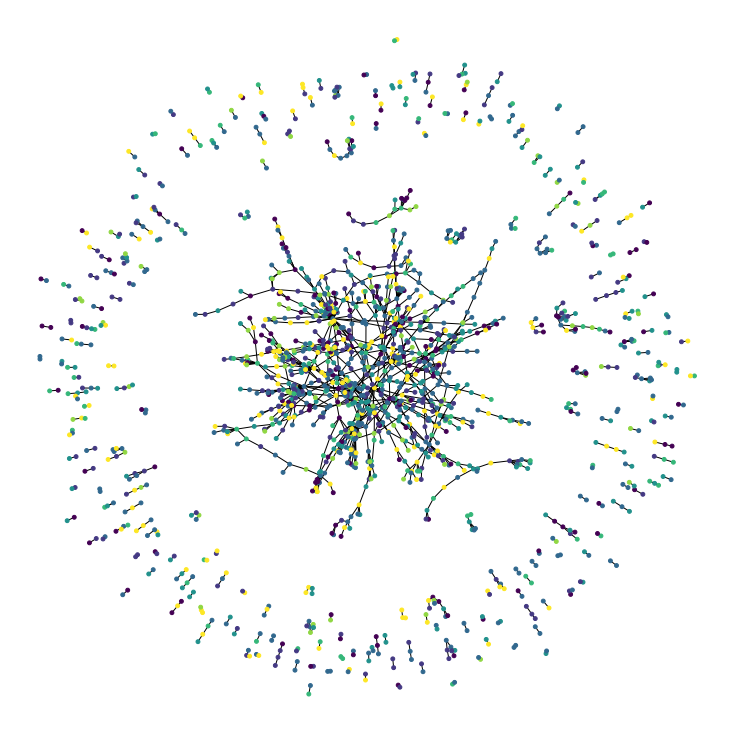

In [11]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [12]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1332, 1435)
Test data shape: (1376, 1435)


In [13]:
test_data

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
1272,1378,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
693,1146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1722,1537,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2034,859,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
401,834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,587,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1127,2681,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2025,1703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2094,2234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [14]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu)) # Maybe Change

    return keras.Sequential(fnn_layers, name=name)

In [15]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [16]:
y_train

375     6
1827    6
1653    0
1046    0
2282    5
       ..
2306    2
342     3
357     1
1463    3
44      0
Name: subject, Length: 1332, dtype: int64

In [17]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [18]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)
        self.normalize = normalize
            
    def prepare(self, node_repesentations, weights=None):

        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):

        num_nodes = tf.math.reduce_max(node_indices) + 1
        
        aggregated_message = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        
        return node_embeddings

    def call(self, inputs):

        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        
        return self.update(node_repesentations, aggregated_messages)

In [19]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [20]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256


gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.12213348 -0.04998919  0.13695551 -0.17981656 -0.37935397  0.02384088
  -0.15028745]
 [ 0.24244504 -0.08599614  0.0608013  -0.16799368 -0.36297342  0.14068095
  -0.01822183]
 [-0.03210312 -0.13179825  0.24338028 -0.22524327 -0.22751032  0.15350536
  -0.03073245]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [21]:


def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [22]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 2s 108ms/step - loss: 2.2999 - acc: 0.1908 - val_loss: 1.9242 - val_acc: 0.2700
Epoch 2/300
5/5 [==============================] - 0s 49ms/step - loss: 2.0006 - acc: 0.2571 - val_loss: 1.9452 - val_acc: 0.1700
Epoch 3/300
5/5 [==============================] - 0s 53ms/step - loss: 1.9220 - acc: 0.2606 - val_loss: 1.9387 - val_acc: 0.2350
Epoch 4/300
5/5 [==============================] - 0s 52ms/step - loss: 1.9011 - acc: 0.2650 - val_loss: 1.9215 - val_acc: 0.2850
Epoch 5/300
5/5 [==============================] - 0s 47ms/step - loss: 1.8801 - acc: 0.2703 - val_loss: 1.9065 - val_acc: 0.2700
Epoch 6/300
5/5 [==============================] - 0s 53ms/step - loss: 1.8606 - acc: 0.2845 - val_loss: 1.8993 - val_acc: 0.2700
Epoch 7/300
5/5 [==============================] - 0s 47ms/step - loss: 1.8702 - acc: 0.2898 - val_loss: 1.8932 - val_acc: 0.2700
Epoch 8/300
5/5 [==============================] - 0s 52ms/step - loss: 1.8318 - acc: 0.2

5/5 [==============================] - 0s 53ms/step - loss: 0.6748 - acc: 0.7845 - val_loss: 0.6627 - val_acc: 0.7900
Epoch 64/300
5/5 [==============================] - 0s 46ms/step - loss: 0.6280 - acc: 0.7906 - val_loss: 0.6496 - val_acc: 0.7750
Epoch 65/300
5/5 [==============================] - 0s 51ms/step - loss: 0.6824 - acc: 0.7783 - val_loss: 0.7105 - val_acc: 0.7800
Epoch 66/300
5/5 [==============================] - 0s 48ms/step - loss: 0.6266 - acc: 0.7906 - val_loss: 0.6697 - val_acc: 0.8150
Epoch 67/300
5/5 [==============================] - 0s 52ms/step - loss: 0.6404 - acc: 0.7951 - val_loss: 0.6556 - val_acc: 0.8050
Epoch 68/300
5/5 [==============================] - 0s 46ms/step - loss: 0.6176 - acc: 0.7977 - val_loss: 0.6958 - val_acc: 0.7800
Epoch 69/300
5/5 [==============================] - 0s 53ms/step - loss: 0.5594 - acc: 0.8180 - val_loss: 0.6798 - val_acc: 0.7850
Epoch 70/300
5/5 [==============================] - 0s 47ms/step - loss: 0.6860 - acc: 0.7818 - 

5/5 [==============================] - 0s 48ms/step - loss: 0.4712 - acc: 0.8454 - val_loss: 0.6539 - val_acc: 0.8150
Epoch 126/300
5/5 [==============================] - 0s 52ms/step - loss: 0.4667 - acc: 0.8648 - val_loss: 0.6382 - val_acc: 0.8150
Epoch 127/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4607 - acc: 0.8454 - val_loss: 0.6392 - val_acc: 0.8150
Epoch 128/300
5/5 [==============================] - 0s 51ms/step - loss: 0.4530 - acc: 0.8569 - val_loss: 0.6541 - val_acc: 0.8150
Epoch 129/300
5/5 [==============================] - 0s 47ms/step - loss: 0.4135 - acc: 0.8728 - val_loss: 0.6936 - val_acc: 0.8000
Epoch 130/300
5/5 [==============================] - 0s 53ms/step - loss: 0.4168 - acc: 0.8763 - val_loss: 0.6838 - val_acc: 0.8000
Epoch 131/300
5/5 [==============================] - 0s 47ms/step - loss: 0.4087 - acc: 0.8746 - val_loss: 0.7210 - val_acc: 0.7950
Epoch 132/300
5/5 [==============================] - 0s 51ms/step - loss: 0.4260 - acc: 0.

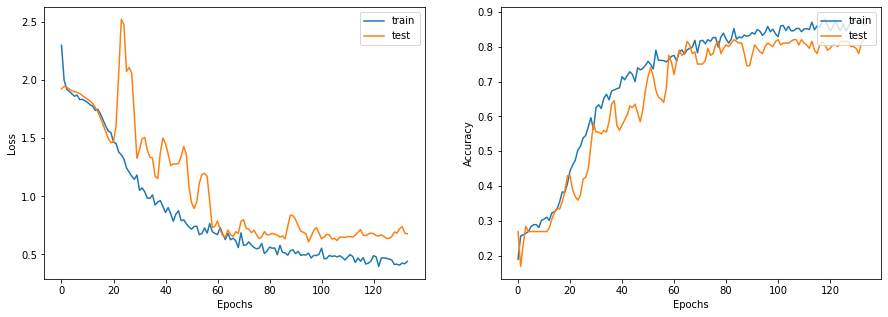

In [23]:
display_learning_curves(history)

In [25]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 77.62%
